In [1]:
using PyPlot

In [2]:
n_workers = 7
n_task_types = 20
n_tasks_per_type = 10
quotas = rand(1:n_tasks_per_type, n_task_types)
horizon = maximum(quotas)
initial_task_lengths = rand(1:n_tasks_per_type, n_task_types)
min_task_lengths = max.(1, initial_task_lengths - rand(1:n_tasks_per_type, n_task_types))
task_bundle_times = [sum(max(min_task_lengths[j], initial_task_lengths[j]-t) for t in 1:T) for j in 1:n_task_types, T in 1:horizon]

20×10 Array{Int64,2}:
 1   2   3   4   5   6   7   8   9  10
 2   3   4   5   6   7   8   9  10  11
 6  11  15  19  23  27  31  35  39  43
 9  17  24  31  38  45  52  59  66  73
 6  11  15  18  20  21  22  23  24  25
 5  10  15  20  25  30  35  40  45  50
 1   2   3   4   5   6   7   8   9  10
 4   7   9  10  11  12  13  14  15  16
 6  11  15  19  23  27  31  35  39  43
 3   5   6   7   8   9  10  11  12  13
 5   9  12  14  15  16  17  18  19  20
 9  17  24  30  35  39  42  44  45  46
 8  15  21  26  30  34  38  42  46  50
 2   3   4   5   6   7   8   9  10  11
 1   2   3   4   5   6   7   8   9  10
 2   3   4   5   6   7   8   9  10  11
 1   2   3   4   5   6   7   8   9  10
 1   2   3   4   5   6   7   8   9  10
 1   2   3   4   5   6   7   8   9  10
 2   3   4   5   6   7   8   9  10  11

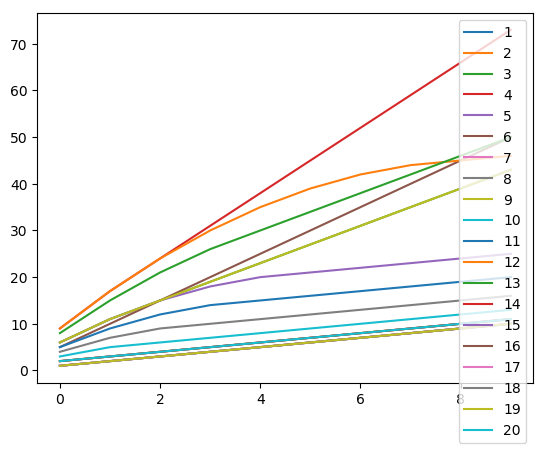

In [3]:
plot(task_bundle_times')
legend(1:n_task_types)
;

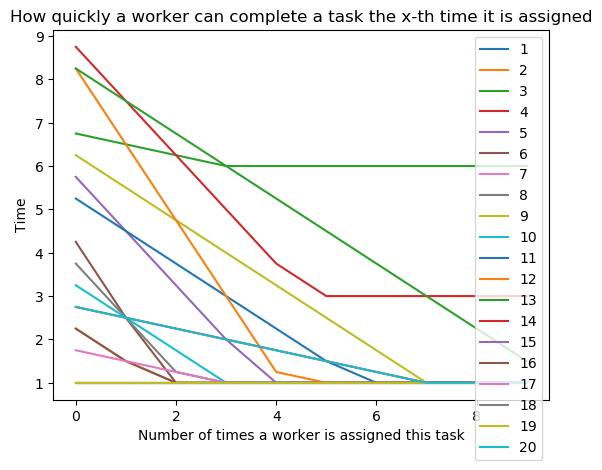

In [4]:
learning_speed = rand(0.25:0.5:1.75, n_task_types)
min_task_lengths = max.(1, initial_task_lengths - rand(1:10, n_task_types))
task_completion_speed = [(max.(min_task_lengths[j], initial_task_lengths[j]-T*learning_speed[j])) for j in 1:n_task_types, T in 1:horizon]

plot(task_completion_speed')
legend(1:n_task_types); xlabel("Number of times a worker is assigned this task"); ylabel("Time")
title("How quickly a worker can complete a task the x-th time it is assigned")
;

In [5]:
task_completion_speed

20×10 Array{Float64,2}:
 1.0   1.0  1.0   1.0  1.0   1.0  1.0   1.0  1.0   1.0
 2.25  1.5  1.0   1.0  1.0   1.0  1.0   1.0  1.0   1.0
 6.75  6.5  6.25  6.0  6.0   6.0  6.0   6.0  6.0   6.0
 8.75  7.5  6.25  5.0  3.75  3.0  3.0   3.0  3.0   3.0
 5.75  4.5  3.25  2.0  1.0   1.0  1.0   1.0  1.0   1.0
 4.25  2.5  1.0   1.0  1.0   1.0  1.0   1.0  1.0   1.0
 1.0   1.0  1.0   1.0  1.0   1.0  1.0   1.0  1.0   1.0
 3.75  2.5  1.25  1.0  1.0   1.0  1.0   1.0  1.0   1.0
 6.25  5.5  4.75  4.0  3.25  2.5  1.75  1.0  1.0   1.0
 3.25  2.5  1.75  1.0  1.0   1.0  1.0   1.0  1.0   1.0
 5.25  4.5  3.75  3.0  2.25  1.5  1.0   1.0  1.0   1.0
 8.25  6.5  4.75  3.0  1.25  1.0  1.0   1.0  1.0   1.0
 8.25  7.5  6.75  6.0  5.25  4.5  3.75  3.0  2.25  1.5
 2.75  2.5  2.25  2.0  1.75  1.5  1.25  1.0  1.0   1.0
 1.0   1.0  1.0   1.0  1.0   1.0  1.0   1.0  1.0   1.0
 2.25  1.5  1.0   1.0  1.0   1.0  1.0   1.0  1.0   1.0
 1.75  1.5  1.25  1.0  1.0   1.0  1.0   1.0  1.0   1.0
 1.0   1.0  1.0   1.0  1.0   1.0  1.0   1

In [6]:
L = rand(0:n_tasks_per_type, n_workers, n_task_types)

7×20 Array{Int64,2}:
 4  0   4  10  7   7  4   3  0  10   8  1  6  1  10  2   2  5  6   0
 3  3  10   3  8   9  5  10  5   3   5  6  1  3   6  0   1  8  0   3
 9  6   7   1  3  10  5   8  5   2  10  9  2  6   9  0   3  4  4   2
 7  9   4   3  0   4  1   4  4   8  10  5  0  7   1  3   4  8  4   2
 6  5   5   6  9   3  7   4  4   5   2  3  0  2   0  3   5  6  9   6
 3  6   3   0  1   1  4   4  1   1   9  5  5  9  10  1  10  9  5  10
 1  0   1   0  1   5  4   1  9   9   4  9  4  9   5  4   5  6  0   0

In [7]:
# task_dur is a matrix where the rows represent workers and columns represent the total time spent working
# on a particular task type
task_dur = zeros(n_workers, n_task_types)

for i=1:n_workers
    for j=1:n_task_types
        for k=1:L[i, j]
            task_dur[i, j] = task_dur[i, j] + task_completion_speed[j, k]
        end
    end
end

task_dur

7×20 Array{Float64,2}:
 4.0   0.0   25.5   46.25  18.5   …  10.0  3.75   3.25  5.0  6.0   0.0 
 3.0   4.75  61.5   22.5   19.5       6.0  0.0    1.75  8.0  0.0   7.5 
 9.0   7.75  43.5    8.75  13.5       9.0  0.0    4.5   4.0  4.0   5.25
 7.0  10.75  25.5   22.5    0.0       1.0  4.75   5.5   8.0  4.0   5.25
 6.0   6.75  31.5   34.25  20.5       0.0  4.75   6.5   6.0  9.0  12.75
 3.0   7.75  19.5    0.0    5.75  …  10.0  2.25  11.5   9.0  5.0  17.0 
 1.0   0.0    6.75   0.0    5.75      5.0  5.75   6.5   6.0  0.0   0.0 

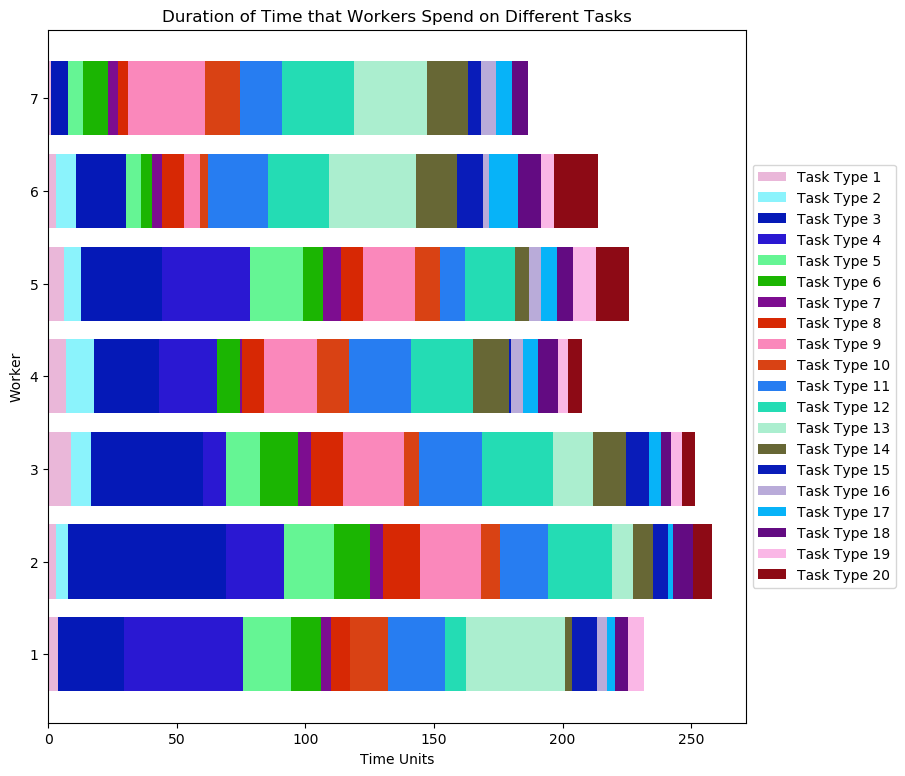

In [11]:
ind = 1:n_workers
width = 0.35

figure(figsize=[9, 9])

colors = rand(n_task_types)
lft = zeros(n_workers)

for j=1:size(task_dur)[2]
    barh(ind, task_dur[:, j], left=lft, color=rand(3), label="Task Type $j")
    lft = lft + task_dur[:, j]
end

ylabel("Worker")
xlabel("Time Units")
title("Duration of Time that Workers Spend on Different Tasks")
legend(loc="center left", bbox_to_anchor=(1, 0.5))
;